**Problem Statement and Hypothesis**

a company wishes to know whether its new landing page performs better than the old one in terms of user conversion. it applies a/b testing to know the answer.

- Null Hypothesis (H₀):  
  There is **no improvement** with the new page.  
  $$
  p_{new} \leq p_{old}
  $$

- Alternative Hypothesis (H₁):  
  The new page performs **better** than the old page.  
  $$
  p_{new} > p_{old}
  $$


**Data Overview**
Columns:
- user_id: Unique user identifier
- timestamp: Date and time of user visit
- group: A/B group (control / treatment)
- landing_page: Page shown (old_page / new_page)
- converted: 1 if the user converted, 0 if not

In [16]:
import pandas as pd
import statsmodels.api as sm 

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
print(df['group'].value_counts())
print(df['landing_page'].value_counts())
print(df['converted'].value_counts())

group
treatment    147276
control      147202
Name: count, dtype: int64
landing_page
old_page    147239
new_page    147239
Name: count, dtype: int64
converted
0    259241
1     35237
Name: count, dtype: int64


- treatment and control group are balanced
- page exposure are equal
- low conversion rate: 259241/35237 = 11.97%
- there is suspicious mismatch in two columns where:
    - 147,202 control users, but 147,239 old_page views
    - 147,276 treatment users, but 147,239 new_page views
    - this is to say that some users do not see page according to their group, if we do not handle this problem, then A/B test can be biased

In [5]:
df_cleaned = df[((df['group'] == 'treatment') & (df['landing_page'] == 'new_page')) |
                ((df['group'] == 'control') & (df['landing_page'] == 'old_page'))]

In [6]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


since the mismatch data being dropped, then total data has changed from 294478 to 290585

In [7]:
df_cleaned.duplicated('user_id').sum()

1

In [8]:
duplicated_user = df_cleaned[df_cleaned.duplicated('user_id')]
print('duplicated:', duplicated_user.shape[0])

duplicated: 1


In [9]:
df_cleaned = df_cleaned.drop_duplicates(subset='user_id', keep='first')

another cleaning data

In [10]:
df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])

timestamp column is change from integer to be datetime

In [11]:
print(df_cleaned['timestamp'].min(), '-->', df_cleaned['timestamp'].max())

2017-01-02 13:42:05.378582 --> 2017-01-24 13:41:54.460509


<Axes: title={'center': 'User per Day'}, xlabel='timestamp'>

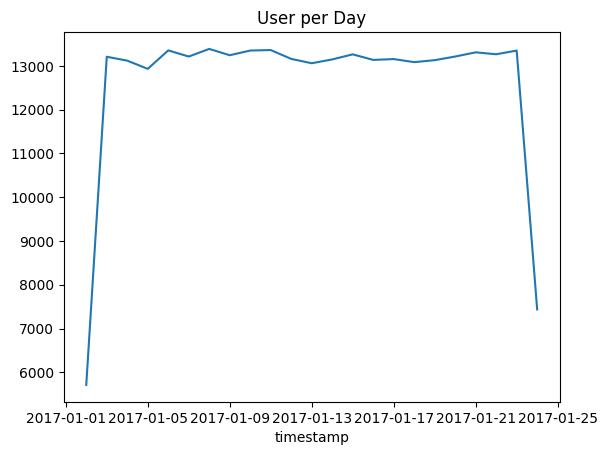

In [12]:
df_cleaned['timestamp'].dt.date.value_counts().sort_index().plot(title='User per Day')

In [13]:
# conversion rate

overall_rate = df_cleaned['converted'].mean()
group_rate = df_cleaned.groupby('group')['converted'].mean().round(4)


print('overall:', overall_rate)
print(group_rate)



overall: 0.11959708724499628
group
control      0.1204
treatment    0.1188
Name: converted, dtype: float64


- overall conversion rate is 11%
- turns out, treatment group conversion rate is slightly lower than the control one, we may say no significant different

In [14]:
# proportion difference

diff = group_rate['treatment'] - group_rate['control']
diff.round(4)

-0.0016

treatment gives negative conversion rate as many as -0.0016

In [15]:
# we wish to test binary data, Z-test is going to be used

convert = df_cleaned.groupby('group')['converted'].agg(['sum', 'count'])

#z-score and p-value
z_score, p_value = sm.stats.proportions_ztest(
    count=[convert.loc['treatment', 'sum'], convert.loc['control', 'sum']],
    nobs=[convert.loc['treatment', 'count'], convert.loc['control', 'count']],
    alternative='larger' #H1 treatment > control
)

print('z-score:', z_score)
print('p-value:', p_value)

alpha = 0.05

if p_value < alpha:
    print("Reject H0: There's evidence that the new page performs better.")
else:
    print("Fail to reject H0: No evidence that the new page performs better.")


z-score: -1.3109241984234394
p-value: 0.9050583127590245
Fail to reject H0: No evidence that the new page performs better.


Failed to reject h0. It means there is no statistical evidence that new page conversion is better than the old one.

## Conclusion

- The z-score is negative, meaning new page is slightly worse than the old page
- Conversion rate is not statistically significant
- For business, we can conclude no performance gain from new page
- No need to deploy the new page anymore because it gives no clear uplift conversion
- Should there will reconsider to use another new page, please reevaluate the design basd on user behaviour insight
